<a href="https://colab.research.google.com/github/Johan1us/Fastai/blob/master/lesson7_superres_for_colab_with_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting Free GPU


Folow **Edit** > **Notebook** **settings** or Runtime>Change runtime type and select **GPU** as Hardware accelerator.

Notes from Hiromis:
https://github.com/hiromis/notes/blob/master/Lesson7.md

Perceptual Losses for Real-Time Style Transfer and Super-Resolution
: https://arxiv.org/abs/1603.08155

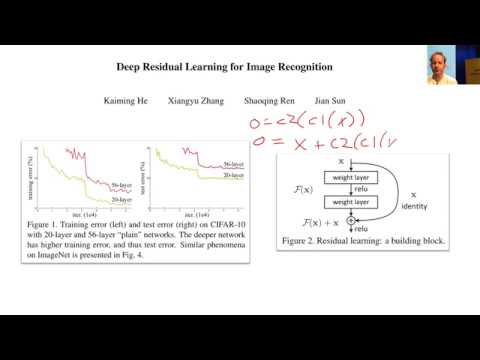

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('nWpdkZE2_cc', width=600, height=400)

I was very excited when we got fast.ai to the point in the last week or so that we had GAN's working in a way where API wise, they're far more concise and more flexible than any other library that exists. But also kind of disappointed with them. They take a long time to train and the outputs are still like so-so, and so the next step was "can we get rid of GANs entirely?" Obviously, the thing we really want to do is come up with a better loss function. We want a loss function that does a good job of saying this is a high-quality image without having to go all the GAN trouble, and preferably it also doesn't just say it's a high-quality image but it's an image which actually looks like the thing is meant to. So the real trick here comes back to this paper from a couple of years ago, Perceptual Losses for Real-Time Style Transfer and Super-Resolution - Justin Johnson et al. created this thing they call perceptual losses. It's a nice paper, but I hate this term because they're nothing particularly perceptual about them. I would call them "feature losses", so in the fast.ai library, you'll see this referred to as feature losses. 

![alt text](https://raw.githubusercontent.com/hiromis/notes/master/lesson7/32.png)

It shares something with GANs which is that after we go through our generator which they call the "image transform net" and you can see it's got this kind of U-Net shaped thing. They didn't actually use U-Nets because at the time this came out, nobody in the machine learning world knew about U-Nets. Nowadays, of course, we use U-Nets. But anyway, something U-Net-ish.

In these kind of architectures where you have a downsampling path followed by an upsampling path, the downsampling path is very often called the encoder as you saw in our code. And the upsampling path is very often called the decoder. In generative models, generally including generative text models, neural translation, stuff like that, they tend to be called the encoder and the decoder - two pieces.

Anyway, so we have this generator and we want a loss function that says "is the thing that it's created like the thing that we want?" and so the way they do that is they take the prediction, remember, \hat{y} is what we normally use for a prediction from a model. We take the prediction and we put it through a pre-trained ImageNet network. At the time that this came out, the pre-trained ImageNet network they were using was VGG. It's kind of old now, but people still tend to use it because it works fine for this process. So they take the prediction, and they put it through VGG - the pre-trained ImageNet network. It doesn't matter too much which one it is.

So normally, the output of that would tell you "hey, is this generated thing a dog, a cat, an airplane, or a fire engine or whatever?" But in the process of getting to that final classification, it goes through lots of different layers. In this case, they've color-coded all the layers with the same grid size and the feature map with the same color. So every time we switch colors, we're switching grid size. So there's a stride 2 conv or in VGG's case they still used to use some maxpooling layers which is a similar idea.

What we could do is say let's not take the final output of the VGG model on this generated image, but let's take something in the middle. Let's take the activations of some layer in the middle. Those activations, it might be a feature map of like 256 channels by 28 by 28. So those kind of 28 by 28 grid cells will kind of roughly semantically say things like "in this part of that 28 by 28 grid, is there something that looks kind of furry? Or is there something that looks kind of shiny? Or is there something that was kind of circular? Is there something that kind of looks like an eyeball?"

So what we do is that we then take the target (i.e. the actual y value) and we put it through the same pre-trained VGG network, and we pull out the activations of the same layer. Then we do a mean square error comparison. So it'll say "in the real image, grid cell (1, 1) of that 28 by 28 feature map is furry and blue and round shaped. And in the generated image, it's furry and blue and not round shape." So it's an okay match.

That ought to go a long way towards fixing our eyeball problem, because in this case, the feature map is going to say "there's eyeballs here (in the target), but there isn't here (in the generated version), so do a better job of that please. Make better eyeballs." So that's the idea. That's what we call feature losses or Johnson et al. called perceptual losses.

To do that, we're going to use the lesson7-superres.ipynb, and this time the task we're going to do is kind of the same as the previous task, but I wrote this notebook a little bit before the GAN notebook - before I came up with the idea of like putting text on it and having a random JPEG quality, so the JPEG quality is always 60, there's no text written on top, and it's 96 by 96. And before I realized what a great word "crappify" is, so it's called resize_one.

## Super resolution

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [0]:
fastai.__version__

'1.0.46'

The notebook works on:
- 1.0.46

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
il = ImageList.from_folder(path_hr)

In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /root/.fastai/data/oxford-iiit-pet/small-96


resizing to 256 into /root/.fastai/data/oxford-iiit-pet/small-256


In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

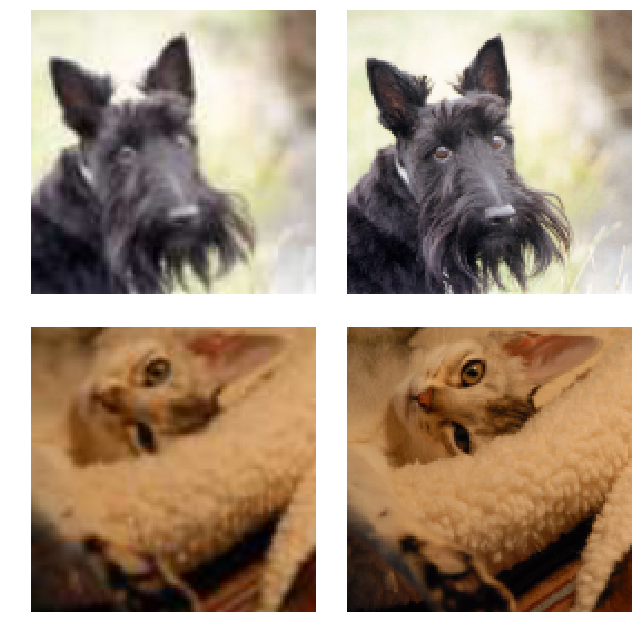

In [0]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

Here's our crappy images and our original images - kind of a similar task to what we had before. I'm going to try and create a loss function which does this (perceptual loss). The first thing I do is I define a base loss function which is basically like "how am I going to compare the pixels and the features?" And the choice is mainly like MSE or L1. It doesn't matter too much which you choose. I tend to like L1 better than MSE actually, so I picked L1.



## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
gram_matrix(t)

tensor([[[0.1580, 0.1535, 0.1404],
         [0.1535, 0.1494, 0.1366],
         [0.1404, 0.1366, 0.1257]],

        [[0.1580, 0.1535, 0.1404],
         [0.1535, 0.1494, 0.1366],
         [0.1404, 0.1366, 0.1257]]])

In [0]:
base_loss = F.l1_loss

So anytime you see base_loss, we mean L1 loss. You could use MSE loss as well.



In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
553507836it [00:23, 23846081.37it/s]


Let's create a VGG model - just using the pre-trained model. In VGG, there's a attribute called .features which contains the convolutional part of the model. So vgg16_bn(True).features is the convolutional part of the VGG model. Because we don't need the head. We only want the intermediate activations.

Then we'll check that on the GPU, we'll put it into eval mode because we're not training it. And we'll turn off requires_grad because we don't want to update the weights of this model. We're just using it for inference (i.e. for the loss).

In [0]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

Then let's enumerate through all the children of that model and find all of the max pooling layers, because in the VGG model that's where the grid size changes. And as you could see from this picture, we want to grab features from every time just before the grid size changes:



![alt text](https://raw.githubusercontent.com/hiromis/notes/master/lesson7/34.png)

So we grab layer i-1. That's the layer before it changes. So there's our list of layer numbers just before the max pooling layers ([5, 12, 22, 32, 42]). All of those are ReLU's, not surprisingly. Those are where we want to grab some features from, and so we put that in blocks - it's just a list of ID's.

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

Here's our feature loss class which is going to implement this idea (perceptual loss).

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

Basically, when we call the feature loss class, we're going to pass it some pre-trained model which is going to be called m_feat. That's the model which contains the features which we want our feature loss on. So we can go ahead and grab all of the layers from that network that we want the features for to create the losses.

We're going to need to hook all of those outputs because that's how we grab intermediate layers in PyTorch is by hooking them. So self.hook is going to contain our our hooked outputs.

Now in the forward of feature loss, we're going to call make_features passing in the target (i.e. our actual y) which is just going to call that VGG model and go through all of the stored activations and just grab a copy of them. We're going to do that both for the target (out_feat) and for the input - so that's the output of the generator (in_feat). Now let's calculate the L1 loss between the pixels, because we still want the pixel loss a little bit. Then let's also go through all of those layers' features and get the L1 loss on them. So we're basically going through every one of these end of each block and grabbing the activations and getting the L1 on each one.

That's going to end up in this list called feat_losses, then sum them all up. By the way, the reason I do it as a list is because we've got this nice little callback that if you put them into thing called .metrics in your loss function, it'll print out all of the separate layer loss amounts for you which is super handy.

So that's it. That's our perceptual loss or feature loss class.



## Train

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:02, 40457561.21it/s]


Now we can just go ahead and train a U-Net in the usual way with our data and pre-trained architecture which is a ResNet 34, passing in our loss function which is using our pre trained VGG model. This (callback_fns) is that callback I mentioned LossMetrics which is going to print out all the different layers losses for us. These are two things (blur and norm_type) that we'll learn about in part 2 of the course, but you should use them.



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


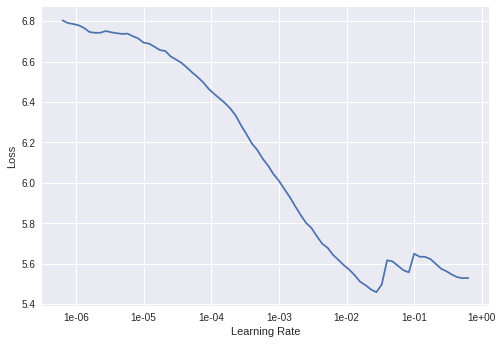

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

I just created a little function called do_fit that does fit one cycle, and then saves the model, and then shows the results.

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
1,3.870538,3.723986,0.139971,0.229351,0.315472,0.223910,0.561141,1.211990,1.042151,04:17
2,3.747008,3.558856,0.141269,0.225548,0.305673,0.212834,0.528805,1.156190,0.988537,04:11
3,3.656551,3.511202,0.155258,0.226274,0.303815,0.208542,0.507285,1.142421,0.967607,04:11
4,3.605892,3.421028,0.137496,0.221649,0.295093,0.204487,0.498655,1.109638,0.954011,04:10
5,3.563752,3.379294,0.141423,0.218756,0.292186,0.202191,0.485374,1.097461,0.941904,04:10
6,3.527776,3.345089,0.139289,0.219573,0.290363,0.200420,0.473389,1.088225,0.933829,04:09
7,3.506061,3.303236,0.139057,0.218372,0.287743,0.197426,0.468483,1.074978,0.917177,04:10
8,3.472098,3.262949,0.134771,0.219103,0.286396,0.193744,0.465404,1.063028,0.900504,04:10
9,3.433251,3.236587,0.136312,0.217378,0.284996,0.193173,0.453063,1.055554,0.896110,04:08
10,3.347272,3.134401,0.131880,0.213712,0.277391,0.187553,0.429131,1.021533,0.873202,04:08


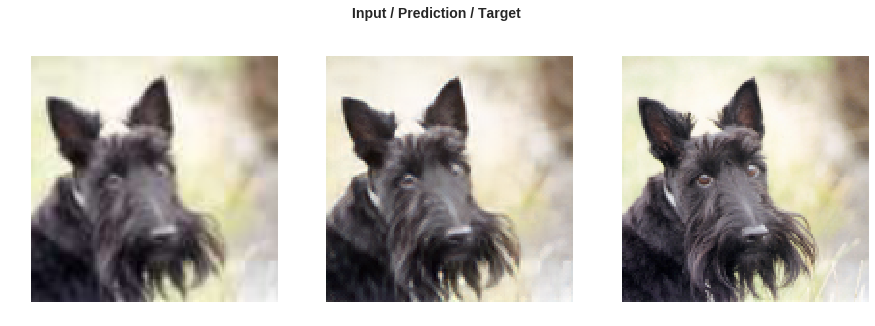

In [0]:
do_fit('1a', slice(lr*10))

As per usual, because we're using a pre-trained network in our U-Net, we start with frozen layers for the downsampling path, train for a while. As you can see, we get not only the loss, but also the pixel loss and the loss at each of our feature layers, and then also something we'll learn about in part 2 called Gram loss which I don't think anybody's used for super resolution before as far as I know. But as you'll see, it turns out great.

That's eight minutes, so much faster than a GAN, and already, as you can see this is our model's output, pretty good. Then we unfreeze and train some more.

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
1,3.297695,3.128144,0.131631,0.213534,0.277021,0.187227,0.427835,1.019406,0.871491,04:20
2,3.299117,3.123513,0.131922,0.213678,0.277012,0.186919,0.426250,1.018535,0.869197,04:19
3,3.319582,3.116961,0.131994,0.213329,0.276635,0.186537,0.424862,1.016568,0.867036,04:19
4,3.316141,3.111744,0.132002,0.213423,0.276288,0.186088,0.422929,1.015823,0.865191,04:20
5,3.306926,3.105246,0.131795,0.212980,0.275831,0.185977,0.421644,1.013005,0.864013,04:21
6,3.291150,3.107820,0.132283,0.213134,0.276009,0.186306,0.420715,1.013930,0.865440,04:20
7,3.278776,3.099492,0.130549,0.212217,0.275155,0.185423,0.421907,1.011915,0.862325,04:20
8,3.262295,3.093387,0.131369,0.212223,0.274959,0.185062,0.419635,1.008795,0.861344,04:20
9,3.272053,3.098125,0.131418,0.212149,0.274422,0.185739,0.420517,1.007489,0.866390,04:19
10,3.260149,3.073995,0.131193,0.211711,0.273506,0.183861,0.416176,1.002690,0.854858,04:18


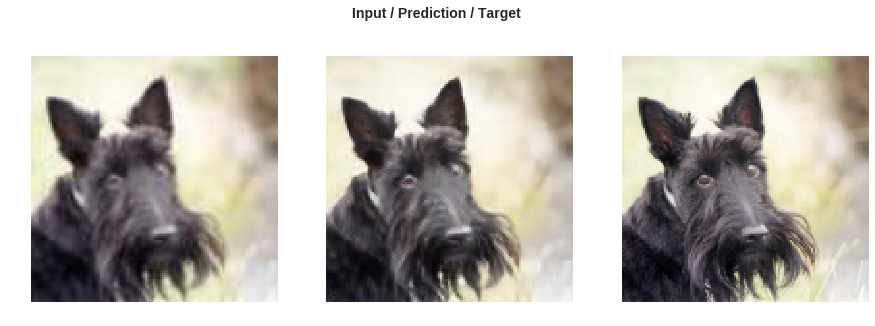

In [0]:
do_fit('1b', slice(1e-5,lr))

And it's a little bit better. Then let's switch up to double the size. So we need to also halve the batch size to avoid running out of GPU memory, and freeze again, and train some more.

In [0]:
data = get_data(12,size*2)

In [0]:
learn.data = data
learn.freeze()
gc.collect()

19342

In [0]:
learn.load('1b');

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
1,2.243670,2.189929,0.158923,0.257606,0.294360,0.154741,0.378789,0.580717,0.364793,18:04
2,2.197082,2.166411,0.159913,0.258640,0.293860,0.154199,0.364779,0.573603,0.361416,17:27
3,2.187847,2.146274,0.159590,0.257974,0.291940,0.152716,0.359707,0.566402,0.357943,17:26
4,2.154377,2.141128,0.161883,0.258164,0.290589,0.151704,0.356436,0.567384,0.354967,17:27
5,2.146266,2.121011,0.160153,0.256219,0.287530,0.149769,0.354419,0.561401,0.351520,17:28
6,2.125891,2.111639,0.162085,0.257140,0.287434,0.149823,0.348862,0.556723,0.349570,17:29
7,2.107437,2.095725,0.161952,0.257187,0.287092,0.149182,0.338969,0.553263,0.348079,17:29
8,2.099030,2.101103,0.163469,0.257483,0.286270,0.148890,0.343079,0.554196,0.347716,17:25
9,2.102331,2.078160,0.162411,0.256256,0.284593,0.147798,0.334710,0.547068,0.345322,17:22
10,2.074239,2.066536,0.161743,0.256308,0.284242,0.147323,0.328523,0.545118,0.343280,17:23


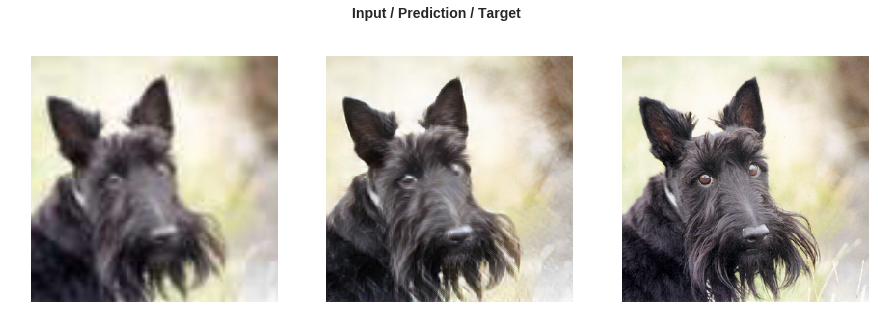

In [0]:
do_fit('2a')

It's now taking half an hour, (the result is) even better. Then unfreeze and train some more.

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
1,2.063155,2.062855,0.161149,0.255256,0.283436,0.146820,0.329973,0.543424,0.342798,17:58
2,2.066849,2.058664,0.160037,0.254986,0.283084,0.146539,0.328846,0.543342,0.341829,17:57
3,2.067518,2.055870,0.160858,0.254968,0.283110,0.146512,0.327522,0.541517,0.341382,17:57
4,2.069862,2.054222,0.160870,0.254803,0.282578,0.146136,0.327808,0.541249,0.340778,17:58
5,2.057184,2.050060,0.160239,0.254228,0.282349,0.145835,0.327350,0.540201,0.339858,17:58
6,2.055947,2.049927,0.160846,0.254835,0.282485,0.145910,0.326078,0.540155,0.339618,18:05
7,2.045311,2.049279,0.160862,0.254768,0.282634,0.145951,0.325761,0.539911,0.339391,18:06
8,2.060037,2.049121,0.160839,0.254443,0.282041,0.145639,0.327090,0.540032,0.339038,18:05
9,2.057688,2.046962,0.160474,0.254471,0.282044,0.145506,0.326237,0.539465,0.338765,18:04
10,2.064811,2.046365,0.160191,0.254347,0.282174,0.145586,0.325827,0.539421,0.338819,18:06


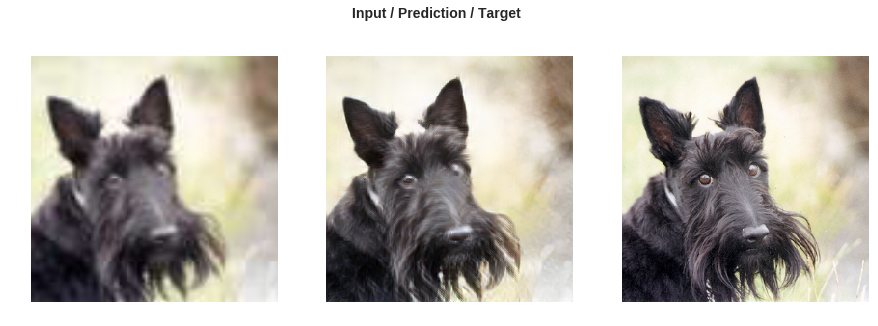

In [0]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

All in all, we've done about an hour and twenty minutes of training and look at that! It's done it. It knows that eyes are important so it's really made an effort. It knows that fur is important so it's really made an effort. It started with something with JPEG artifacts around the ears and all this mess and eyes that are just kind of vague light blue things, and it really created a lot of texture. This cat is clearly looking over the top of one of those little clawing frames covered in fuzz, so it actually recognized that this thing is probably a carpeting materials. It's created a carpeting material for us. So I mean, that's just remarkable.

Talking for markable, I've mean I've never seen outputs like this before without a GAN so I was just so excited when we were able to generate this and so quickly - one GPU, an hour and a half. If you create your own crappification functions and train this model, you'll' build stuff that nobody's built before. Because nobody else that I know of is doing it this way. So there are huge opportunities, I think. So check this out.

## Test

[1:31:45](https://www.youtube.com/watch?v=nWpdkZE2_cc&feature=youtu.be&t=5505)

What we can now do is we can now, instead of starting with our low res, I actually stored another set at size 256 which are called medium res, so let's see what happens if we up size a medium res

In [0]:
learn = None
gc.collect();

In [0]:
256/320*1024

819.2

In [0]:
256/320*1600

1280.0

In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 9970MB of GPU RAM free


In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
learn.load('2b');

In [0]:
learn.data = data_mr

In [0]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/root/.fastai/data/oxford-iiit-pet/small-256/scottish_terrier_71.jpg')

In [0]:
img = open_image(fn); img.shape

torch.Size([3, 256, 365])

In [0]:
p,img_hr,b = learn.predict(img)

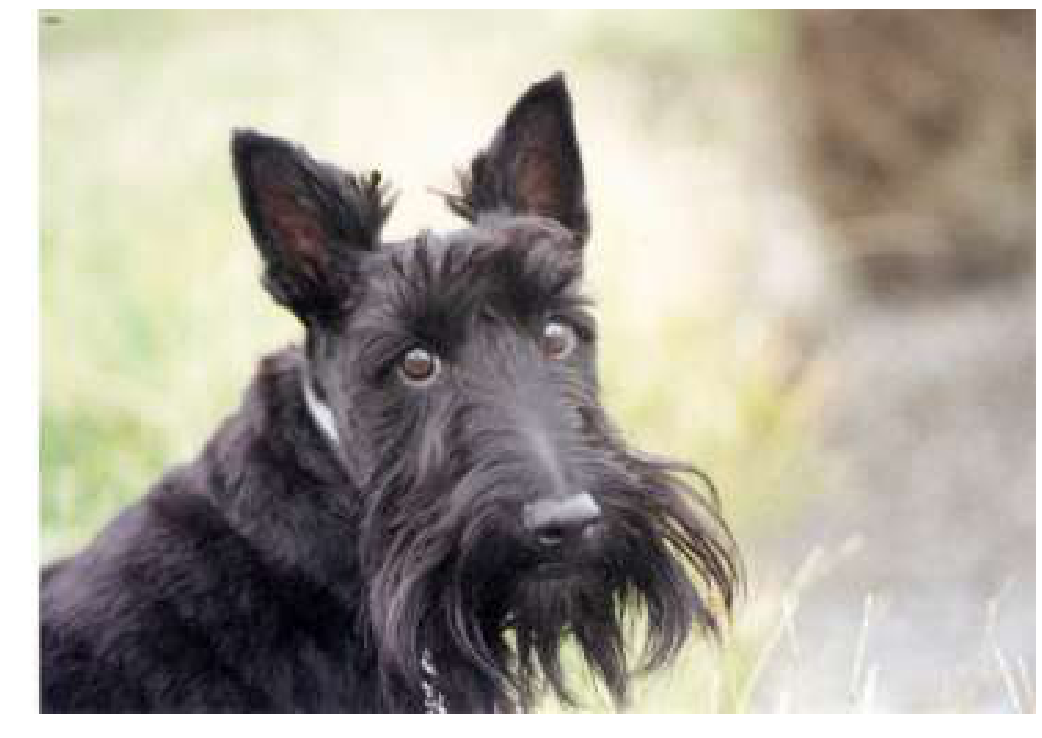

In [0]:
show_image(img, figsize=(18,15), interpolation='nearest');

We're going to grab our medium res data, and here is our medium res stored photo. Can we improve this? You can see, there's still a lot of room for improvement. The lashes here are very pixelated. The place where there should be hair here is just kind of fuzzy. So watch this area as I hit down on my keyboard:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


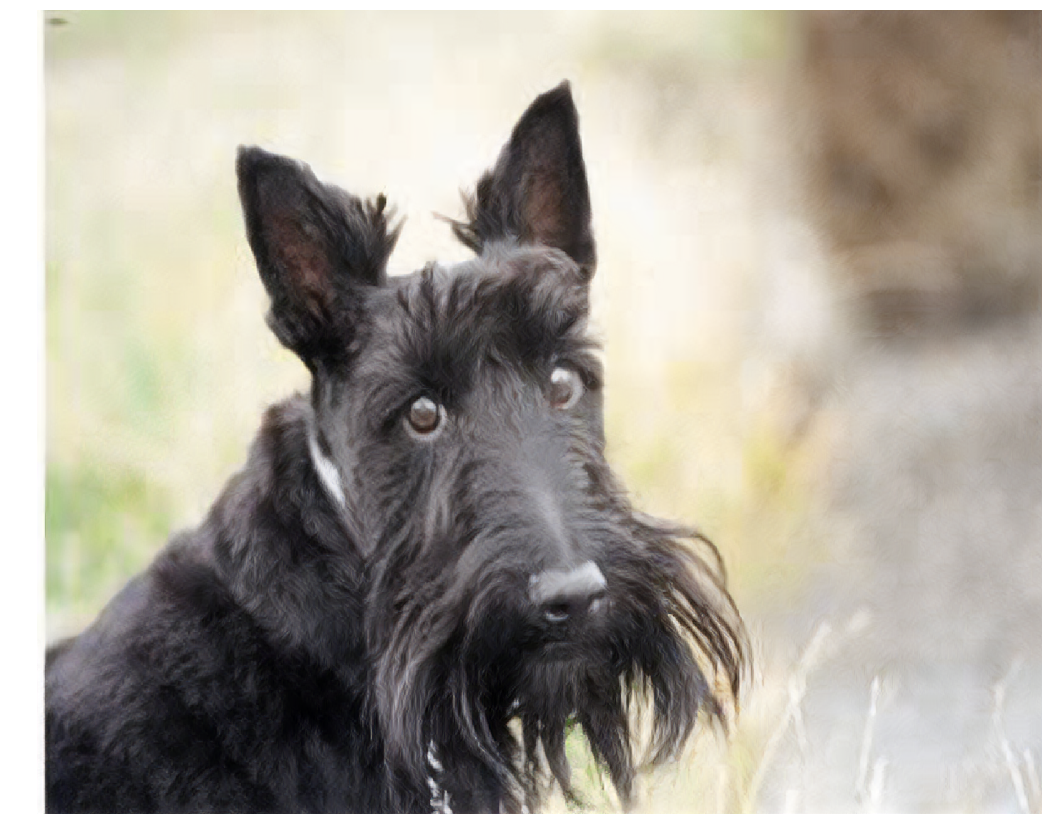

In [0]:
Image(img_hr).show(figsize=(18,15))

Look at that. It's done it. It's taken a medium res image and it's made a totally clear thing here. The furs reappeared. But look at the eyeball. Let's go back. The eyeball here (the before) is just kind of a general blue thing, here (the after) it's added all the right texture. So I just think this is super exciting. Here's a model I trained in an hour and a half using standard stuff that you've all learnt about a U-Net, a pre trained model, feature loss function and we've got something which can turn that medium res into that high res, or this absolute mess into this. It's really exciting to think what could you do with that.



![alt text](https://cdn-images-1.medium.com/max/800/1*Yi64yzIRh5iH3p2Blh8GvA.jpeg)